# Final Project - Coursera


## Goal
 - This challenge serves as final project for the "How to win a data science competition" Coursera course.
 - In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 
 - We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

# Load libraries

In [38]:
# Importando bibliotecas que serao utilizadas neste projeto
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from multiprocessing import Pool

# Models
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

import pickle
import datetime
import time
import gc

# Import Data

In [ ]:
DATA_FOLDER = 'data/origin/'

train           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train_v2.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv')).set_index('ID')
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shop            = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
submission      = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

# Part 1. EDA & Feature Engineering

In [ ]:
print('Transactions: ', train.shape)
print('Test:', test.shape)
print('Items: ', items.shape)
print('Item Categories: ', item_categories.shape)
print('Shops:', shop.shape)

In [ ]:
shop.head()
shop.describe()
shop.shop_id.unique()

In [ ]:
item_categories.head()
item_categories.describe()
item_categories.item_category_id.unique()

In [ ]:
items.head()
items.describe()
items.item_id.unique().shape[0]

In [ ]:
test.head()
submission.head()

In [ ]:
train.head()
train.describe()

In [ ]:
train.date_block_num.plot()

In [ ]:
train.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)

### Plot the feature distributions

In [ ]:
def box_plot(df,f):
    plt.figure(figsize=(10,4))
    plt.title(f+' distribution')
    x_min = int(df[f].min() - (abs(df[f].min())*0.1))
    x_max = int(df[f].max() + (abs(df[f].max())*0.1))
    if x_min==0:
        x_min = -1
    if x_max==0:
        x_max = 1
    plt.xlim(x_min,x_max)
    sns.boxplot(x=df[f])

plot_features = [x for x in train.columns.values if train[x].dtype != 'object']
for f in plot_features:
    box_plot(train,f)

### Outliers removal

In [ ]:
test.merge(train, how='left', on=['shop_id', 'item_id']).isnull().sum()
test.shape[0]

In [ ]:
train.item_price.plot()
train[train['item_price'] > 100000]
items[items['item_id'] == 6066]

In [ ]:
train.item_cnt_day.plot()
train[train['item_cnt_day'] > 900]
items[(items['item_id'] == 11373) & (items['item_id'] == 20949)]

In [ ]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day <= 900]

## Aggregate Data

In [ ]:
# Merge duplicate shops
train.loc[train.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11

In [ ]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [ ]:
train_m = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
train_m = pd.merge(grid,train_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

train_m = pd.merge(train_m,items,on=['item_id'],how='left')
train_m = pd.merge(train_m,item_categories, on=['item_category_id'], how='left')

## Mean encoding

In [ ]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = train_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        train_m = pd.merge(train_m,mean_df,on=['date_block_num', type_id],how='left')

## Prepare test set

In [ ]:
temp_test = test.copy()
temp_test['date_block_num'] = 34

temp_test = temp_test.merge(items, how='left', on='item_id')
temp_test = temp_test.merge(item_categories, how='left', on='item_category_id')
temp_test.drop('item_name', axis=1, inplace=True)

## Concat Train and Test

In [ ]:
train_m.drop('item_name', axis=1, inplace=True)
train_m = pd.concat([train_m,temp_test], axis=0, ignore_index=True)

We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

The month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard.

In [ ]:
lag_variables  = ['item_id_avg_item_price',
                  'item_id_sum_item_cnt_day',
                  'item_id_avg_item_cnt_day',
                  'shop_id_avg_item_price',
                  'shop_id_sum_item_cnt_day',
                  'shop_id_avg_item_cnt_day',
                  'item_category_id_avg_item_price',
                  'item_category_id_sum_item_cnt_day',
                  'item_category_id_avg_item_cnt_day',
                  'item_cnt_day']

lags = [1, 2, 3, 4, 5, 6, 9, 12]

for lag in lags:
    train_new_df = train_m.copy()
    train_new_df.date_block_num+=lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    train_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    train_m = train_m.merge(train_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [ ]:
train_m.describe()

### Create new time related features

In [ ]:
# Month number
train_m['month'] = train_m['date_block_num']%12
train_m['month'] = train_m['month']

# Number of days in a month, no leap years here
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_m['days'] = train_m['month'].map(days)

### Missing values

In [ ]:
for feat in train_m.columns:
    if 'item_cnt' in feat:
        train_m[feat]=train_m[feat].fillna(0)
    elif 'item_price' in feat:
        train_m[feat]=train_m[feat].fillna(train_m[feat].median())

### Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.

In [ ]:
cols_to_drop = lag_variables[:-1] + ['item_price']
train_m = train_m[train_m['date_block_num'] > 12]

## Validation

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing.

In [ ]:
X_train = train_m[train_m['date_block_num'] < 33].drop(cols_to_drop, axis=1)
X_cv    = train_m[train_m['date_block_num'] ==33].drop(cols_to_drop, axis=1)
X_test  = train_m[train_m['date_block_num'] ==34].drop(cols_to_drop, axis=1)

## Reference from discussion

From discussion in Kaggle forum, we applied this useful trick, which clip the item_cnt_day within 40 instead of 20. In this way, there are more predictions on item_cnt_day = 20.

In [ ]:
X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)

X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)

X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

### Save files

In [ ]:
X_train.to_csv('data/files/X_train.csv', index=False)
X_cv.to_csv('data/files/X_cv.csv', index=False)
X_test.to_csv('data/files/X_test.csv', index=False)

# Part 2. Modelling

## 3 distinctively different models are used:

- Ridge Regression (Linear)
- LightGBM (Tree based)
- XGBoost (Tree based)
- After each model has been trained, a stacked ensemble model which the three models

### Data preparation

In [3]:
X_train = pd.read_csv('data/files/X_train.csv')
X_cv    = pd.read_csv('data/files/X_cv.csv')

In [66]:
cols = [c for c in X_train.columns if c not in ['item_category_name', 'date_block_num', 'item_cnt_day',]]

train_x = X_train[cols]
train_y = X_train['item_cnt_day']
val_x   = X_cv[cols]
val_y   = X_cv['item_cnt_day']

features = list(train_x.columns.values)

scoresRMSLE = {}

In [7]:
# Normalise data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x.values)

train_x_norm = scaler.transform(train_x.values)
val_x_norm   = scaler.transform(val_x.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
def post_processing(model, model_name, train_x, train_y, val_x, val_y):
    train_pred = model.predict(train_x)
    val_pred   = model.predict(val_x)

    # Get rmse scores
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    print("Train RMSE: %f" % (train_rmse))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    print("Val RMSE: %f" % (val_rmse))

    scoresRMSLE[model_name] = (train_rmse, val_rmse)
    
    return train_pred,val_pred

In [11]:
def plot_feature_importances(importances,indices,features,title,dimensions):
    plt.figure(figsize=dimensions)
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()   

## Ridge Regression

In [12]:
# Training
gc.collect()
ts = time.time()

lm = linear_model.Ridge()
lm.fit(train_x_norm, train_y)
print ('Training time: %s' %(time.time() - ts))

264

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Training time: 9.104081153869629


In [20]:
# Performance and test predictions
train_pred1, val_pred1 = post_processing(lm, 'Rigde',
                                         train_x_norm, train_y,
                                         val_x_norm, val_y)

Train RMSE: 1.230800
Val RMSE: 1.248100


## LightGBM

In [23]:
# Training
gc.collect()
ts = time.time()

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor()
lightgbm.fit(train_x_norm, train_y)

print ('Training time: %s' %(time.time() - ts))

35

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Training time: 53.62805891036987


In [24]:
# Performance and test predictions
train_pred2, val_pred2 = post_processing(lightgbm, 'lightgbm',
                                         train_x_norm, train_y,
                                         val_x_norm, val_y)

Train RMSE: 0.974506
Val RMSE: 1.151710


## XGBoost

In [25]:
# Training
gc.collect()
ts = time.time()

xgbtrain = xgb.DMatrix(train_x.values, train_y.values)

params = {'max_depth':7, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.08, 
         'num_round':100, 
         'seed':3,
         'silent':True,
         'eval_metric':'rmse'}

bst = xgb.train(params, xgbtrain)
print ('Training time: %s' %(time.time() - ts))

131

Training time: 1030.5312869548798


In [29]:
# Performance and test predictions
train_pred3, val_pred3 = post_processing(bst, 'xgboost',
                                         xgb.DMatrix(train_x.values), train_y,
                                         xgb.DMatrix(val_x.values), val_y)

Train RMSE: 1.165714
Val RMSE: 1.208875


<Figure size 576x1152 with 0 Axes>

Text(0.5, 1.0, 'XGBoost Feature Importances')

<BarContainer object of 77 artists>

([<matplotlib.axis.YTick at 0x1a3929a6a0>,
 <a list of 77 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

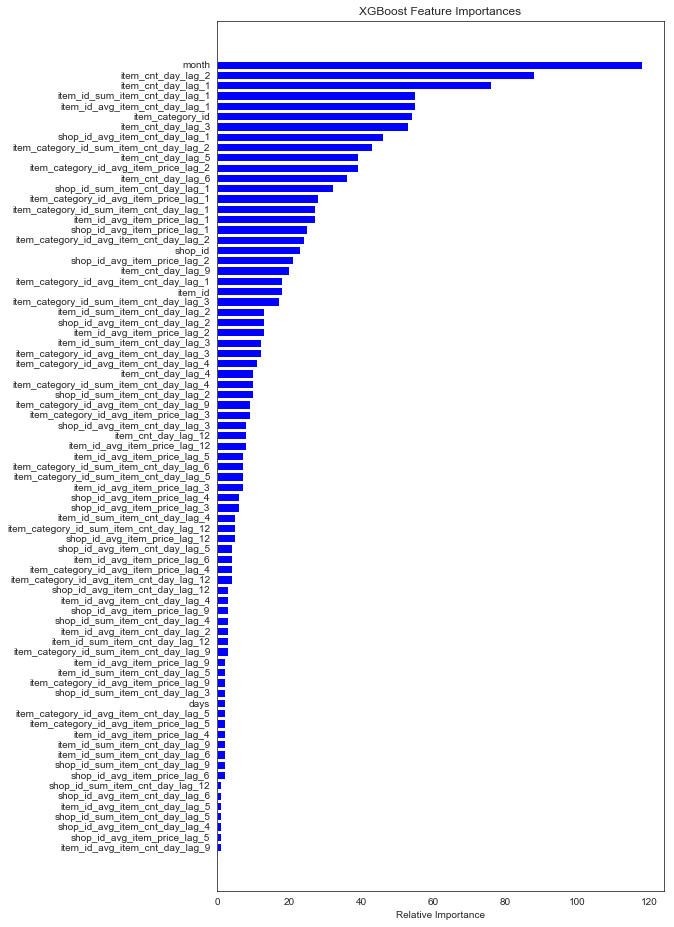

In [32]:
# Feature Importance
import operator
importance = sorted(bst.get_score().items(), key=operator.itemgetter(1))
importance_v = np.asarray([x[1] for x in importance],dtype=np.int16)
indices = np.asarray([int(x[0].replace('f','')) for x in importance],dtype=np.int8)
title = 'XGBoost Feature Importances'

plt.figure(figsize=(8,16))
plt.title(title)
plt.barh(range(len(indices)), importance_v, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## StackingCVRegressor

In [ ]:
# Training
gc.collect()
ts = time.time()

xgboost = XGBRegressor(objective='reg:squarederror')

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(lm, lightgbm, xgboost),
                                meta_regressor=xgboost,
                                random_state=3,
                                use_features_in_secondary=True)

stack_gen.fit(train_x_norm, train_y)
print ('Training time: %s' %(time.time() - ts))

In [ ]:
# Performance and test predictions
train_pred4, val_pred4 = post_processing(stack_gen, 'stack_gen',
                                         train_x_norm, train_y,
                                         val_x_norm, val_y)

## Results

In [43]:
print(scoresRMSLE)

{'Rigde': (1.2308003512804608, 1.2481000755021852), 'lightgbm': (0.9745058935896556, 1.1517103073204957), 'xgboost': (1.1657141035621639, 1.2088745765746758)}


Text(0, 1.2308003512804608, '1.2308')

Text(1, 0.9745058935896556, '0.9745')

Text(2, 1.1657141035621639, '1.1657')

Text(0, 0.5, 'Score (RMSE)')

Text(0.5, 0, 'Algoritmos de Machine Learning')

Text(0.5, 1.0, 'Scores dos Modelos (RMSE)')

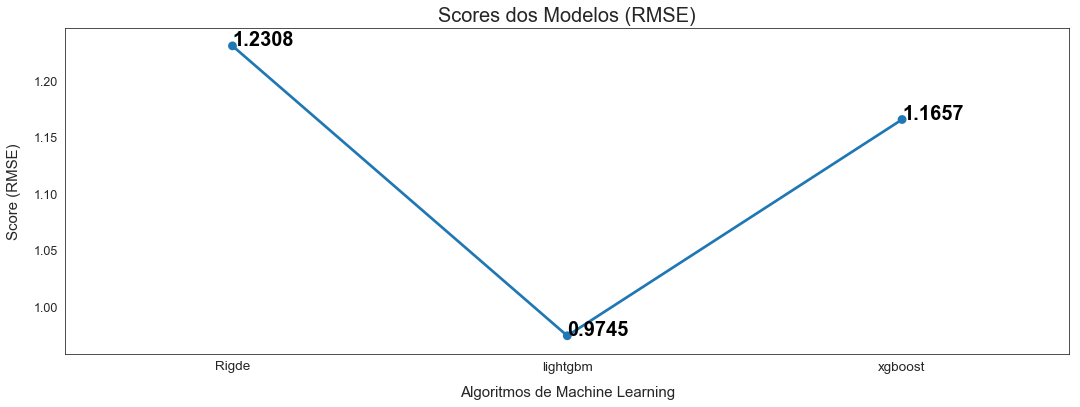

In [44]:
# Plot models performance
sns.set_style("white")
fig = plt.figure(figsize=(18, 6))

ax = sns.pointplot(x=list(scoresRMSLE.keys()), y=[resRMSE for resRMSE, _ in scoresRMSLE.values()], markers=['o'], linestyles=['-'])
for i, resRMSE in enumerate(scoresRMSLE.values()):
    ax.text(i, resRMSE[0] , '{:.4f}'.format(resRMSE[0]), horizontalalignment='left', color='black', weight='semibold', size='20')

plt.ylabel('Score (RMSE)', size=15, labelpad=12.5)
plt.xlabel('Algoritmos de Machine Learning', size=15, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores dos Modelos (RMSE)', size=20)

plt.show()

## Save XGBoost Model and make predictions and submission

In [67]:
test   = pd.read_csv('data/origin/test.csv')
X_test = pd.read_csv('data/files/X_test.csv')

In [61]:
X_test.head()

,date_block_num,item_category_id,item_category_name,item_cnt_day,item_id,shop_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,...,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12,month,days
0,34,19,Игры - PS3,0.0,5037,5,579.159091,25.0,0.568182,111.209795,...,1.3,120.061591,1445.0,0.228567,452.155684,6134.0,0.625918,1.0,10,30
1,34,55,Музыка - CD локального производства,0.0,5320,5,34.813953,0.0,0.000000,102.626336,...,0.0,97.347128,0.0,0.000000,44.715254,0.0,0.000000,0.0,10,30
2,34,19,Игры - PS3,0.0,5233,5,735.750000,42.0,0.954545,111.209795,...,0.0,97.347128,0.0,0.000000,44.715254,0.0,0.000000,0.0,10,30
3,34,23,Игры - XBOX 360,0.0,5232,5,511.909091,28.0,0.636364,111.209795,...,0.0,97.347128,0.0,0.000000,44.715254,0.0,0.000000,0.0,10,30
4,34,20,Игры - PS4,0.0,5268,5,34.813953,0.0,0.000000,102.626336,...,0.0,97.347128,0.0,0.000000,44.715254,0.0,0.000000,0.0,10,30


In [ ]:
cols = [c for c in X_train.columns if c not in ['item_category_name', 'date_block_num', 'item_cnt_day',]]

train_x = X_train[cols]
train_y = X_train['item_cnt_day']
val_x   = X_cv[cols]
val_y   = X_cv['item_cnt_day']

model = xgb.train(params, xgb.DMatrix(train_x, train_y))

In [ ]:
pred = model.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model.best_ntree_limit)

test['item_cnt_month'] = pred.clip(0,40)
test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('data/submission/submission_final.csv', index=False)